# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/kaggle/kaggle_practice/항공사진_선인장_식별'

/content/drive/MyDrive/kaggle/kaggle_practice/항공사진_선인장_식별


# EDA

## 데이터 탐색

In [5]:
import pandas as pd 

data_path = 'dataset/'
labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [6]:
from zipfile import ZipFile

with ZipFile(data_path + 'train.zip') as zipper : 
  zipper.extractall()
with ZipFile(data_path + 'test.zip') as zipper : 
  zipper.extractall()  

In [7]:
labels.head(5)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
submission.head(5)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


## Data Visualization

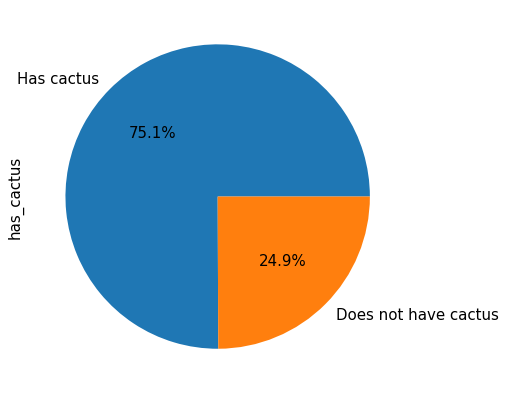

In [9]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline 

mpl.rc('font', size = 15)
plt.figure(figsize = (7, 7))
label =  ['Has cactus', 'Does not have cactus']
labels['has_cactus'].value_counts().plot.pie(labels = label, autopct = '%.1f%%')

In [10]:
import os 

num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'# of train : {num_train}')
print(f'# of test : {num_test}')

# of train : 17500
# of test : 4000


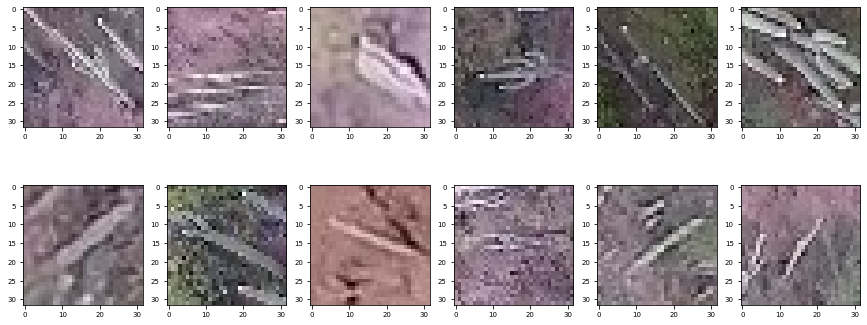

In [11]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus'] == 1]['id'][-12:]
last_has_cactus_img_name

for idx, img_name in enumerate(last_has_cactus_img_name) : 
  img_path = 'train/' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

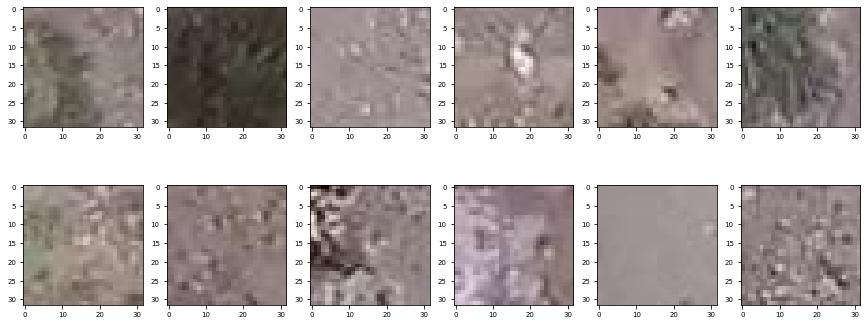

In [12]:
mpl.rc('font', size = 7)
plt.figure(figsize = (15, 6))
grid = gridspec.GridSpec(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_not_has_cactus_img_name = labels[labels['has_cactus'] == 0]['id'][-12:]
last_not_has_cactus_img_name

for idx, img_name in enumerate(last_not_has_cactus_img_name) : 
  img_path = 'train/' + img_name # 이미지 파일 경로
  image = cv2.imread(img_path) # 이미지 파일 읽어오기
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
  ax = plt.subplot(grid[idx]) 
  ax.imshow(image) # 이미지 출력

In [13]:
image.shape # 가로 32 x 세로 32 x 3채널 (R, G, B)

(32, 32, 3)

# 모델 성능 개선
파이토치를 활용해서 모델을 생성 (CNN)
- 시드값 고정 및 GPU 장비 설정
  - 시드값 고정은 결과 재현을 위한 작업
- 데이터 준비
  - 1. 훈련/검증 데이터 분리
  - 2. 데이터셋 클래스 정의
  - 3. 데이터셋 생성
  - 4. 데이터 로더 생성
- 모델 생성 (CNN)
  - 신경망 모델 클래스를 직접 설계한 후 인스턴스 생성
- 모델 훈련
  - 1. Loss function과 optimizer 설정
  - 2. 모델 훈련
- 성능 검증
- 예측 및 제출

## 시드값 고정 및 GPU 장비 설정

### 시드값 고정

파이토치로 딥러닝 모델링을 할 때는 모델 훈련시에 시드값을 설정하는 것이 아니라 처음에 고정한다.

In [14]:
import torch 
import random 
import numpy as np 
import os 

seed = 50 
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed) # 파이썬 난수 생성기 시드 고정 
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정 
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (CPU)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (GPU)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 GPU 사용 시) 
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enables = False # cudnn 사용 해제

### GPU 장비 설정

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

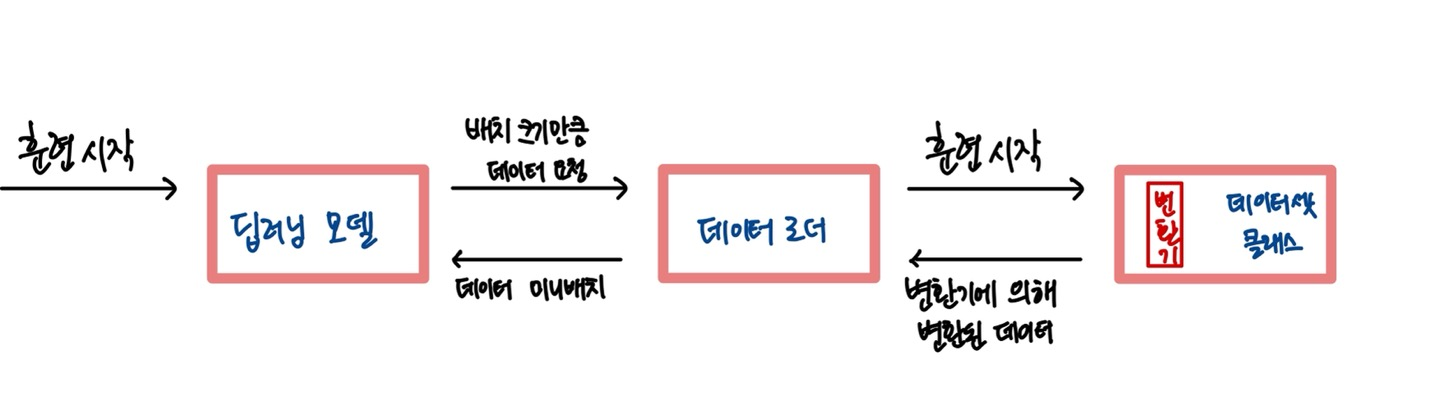

# 성능 개선

## 데이터 준비

### 훈련 데이터, 검증 데이터 분리
labels에는 주최 측에서 제공한 train.csv 파일의 내용이 담겨있다. `train_test_split()` 함수를 이용해 이 데이터를 훈련 데이터와 검증 데이터로 나눈다.

In [16]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [17]:
from sklearn.model_selection import train_test_split 

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels,
                                test_size = .1, 
                                stratify = labels['has_cactus'],
                                random_state = 50)

print(f'# of train data : {len(train)}')
print(f'# of valid data : {len(valid)}')

# of train data : 15750
# of valid data : 1750


### 데이터셋 클래스 준비

In [18]:
import cv2 
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

파이토치의 Dataset 클래스를 활용해서 데이터셋 객체를 만들 수 있다.

 Dataset 클래스는 추상 클래스이며, Dataset 클래스를 상속받은 다음 특수 메서드인 `__len__()`과 `__getitem__()` 을 오버라이딩 해야한다.
- `__len()__` : 데이터셋 크기를 반환
- `__getitem()__`: 인덱스를 전달받아 인덱스에 해당하는 데이터 반환

> 추상 클래스는 곧바로 객체를 생성할 수 없고 상속만 할 수 있는 클래스이다. 이를 사용하는 이유는 상속받는 클래스들의 메서드를 규격화하기 위해서이다. (상속을 강제해 메서드 시그니처를 일치시키기 위함)

In [19]:
class ImageDataset(Dataset) : 
  # 초기화 메서드 (생성자)
  def __init__(self, df, img_dir = './', transform = None) : 
    super().__init__() # 상속받은 Dataset의 생성자 호출
    
    # 전달받은 인수들 저장
    self.df = df
    self.img_dir = img_dir
    self.transform = transform

  # 데이터셋 크기 반환 메서드
  def __len__(self) :
    return len(self.df)

  # 인덱스에 해당하는 데이터 반환 메서드
  def __getitem__(self, idx) : 
    img_id = self.df.iloc[idx, 0]
    img_path = self.img_dir + img_id
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.df.iloc[idx, 1]

    if self.transform is not None : 
      image = self.transform(image)
    return image, label

### 이미지 변환과 데이터 증강

많이 쓰이는 이미지 변환은 다음과 같다.
- 가장자리 제거
- 좌우 반전
- 회전
- 크기 변경
- 노이즈
- 색상 변경
- 차단
- 흐릿하게 만들기
> 이미지를 변환하여 데이터 수를 늘리는 방식을 **데이터 증강(Data augmentation)**이라고 한다.

파이토치의 컴퓨터 비전 라이브러리인 torchvision의 transforms 모듈이 제공하는 주요 변환기들은 다음과 같다.
- Compose() : 여러 변환기를 묶어줌
- ToTensor() : PIL(Python Imaging Library) 이미지나 ndarray를 텐서로 변환
- Pad() : 이미지 주변에 패딩 추가
- RandomHorizontalFlip() : 이미지를 무작위로 좌우 대칭 변환
- RandomVerticalFlip() : 이미지를 무작위로 상하 대칭 변환
- RandomRatation() : 이미지를 무작위로 회전
- Normalizer() : 텐서 형태의 이미지 데이터를 정규화


### 이미지 변환기 정의
훈련 데이터용과 검증 및 테스트 데이터용을 따로 만들어야 한다. 훈련 시에는 모델을 다양한 상황에 적응시키는 게 좋지만 평가 및 테스트 시에는 원본 이미지와 너무 달라지면 예측하기 어려워지기 때문이다. 

In [23]:
from torchvision import transforms 

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(), # 이미지를 텐서 객체로 변환
                                      transforms.Pad(32, padding_mode = 'symmetric'), # 32를 전달했으므로 32x32 이미지 주변에 32 두께의 패딩을 둘러 96x96 이미지가 된다.
                                      transforms.RandomHorizontalFlip(), # 좌우 대칭(변환할 이미지의 비율 지정할 수 있으며, 지정하지 않으면 50%)
                                      transforms.RandomVerticalFlip(), # 상하 대칭(변환할 이미지의 비율 지정할 수 있으며, 지정하지 않으면 50%)
                                      transforms.RandomRotation(10), # 이미지 회전 (파라미터로 n을 전달하면 -n도 ~ n도 사이의 값만큼 무작위로 회전)
                                      transforms.Normalize((0.485, 0.456, 0.406), # R, G, B 채널에 전달할 평균과 분산으로 ImageNet으로부터 구해진 값
                                                             (0.229, 0.224, 0.225))]) 

# 검증 및 테스트 데이터용 변환기 
transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode = 'symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])

### 데이터셋 및 데이터 로더 생성

In [24]:
# 데이터셋 
dataset_train = ImageDataset(df = train, img_dir = 'train/', transform = transform_train)
dataset_valid = ImageDataset(df = valid, img_dir = 'train/', transform = transform_test)

# 데이터 로더
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset = dataset_train, batch_size = 32, shuffle = True)
loader_valid = DataLoader(dataset = dataset_valid, batch_size = 32, shuffle = False)

RandomHorizontalFlip(), RandomVerticalFlip(), RandomRotation()에서 변환을 무작위로 하기 때문에 에폭마다 서로 다른 이미지로 훈련하는 효과를 얻을 수 있다.

## 모델 생성
베이스라인에서는 합성곱과 최대 풀링 계층이 두 개씩 있고, 평균 풀링 계층과 전결합 계층이 있다. 

이번에는 더 깊은 CNN을 만든다. 보통 신경망 계층이 깊어지면 예측력이 좋아진다. 다만 지나치게 깊으면 과대적합이 될 수 있다. 

배치 정규화를 적용하고 활성화 함수를 Leaky ReLU로 바꿔서 성능을 높인다. 

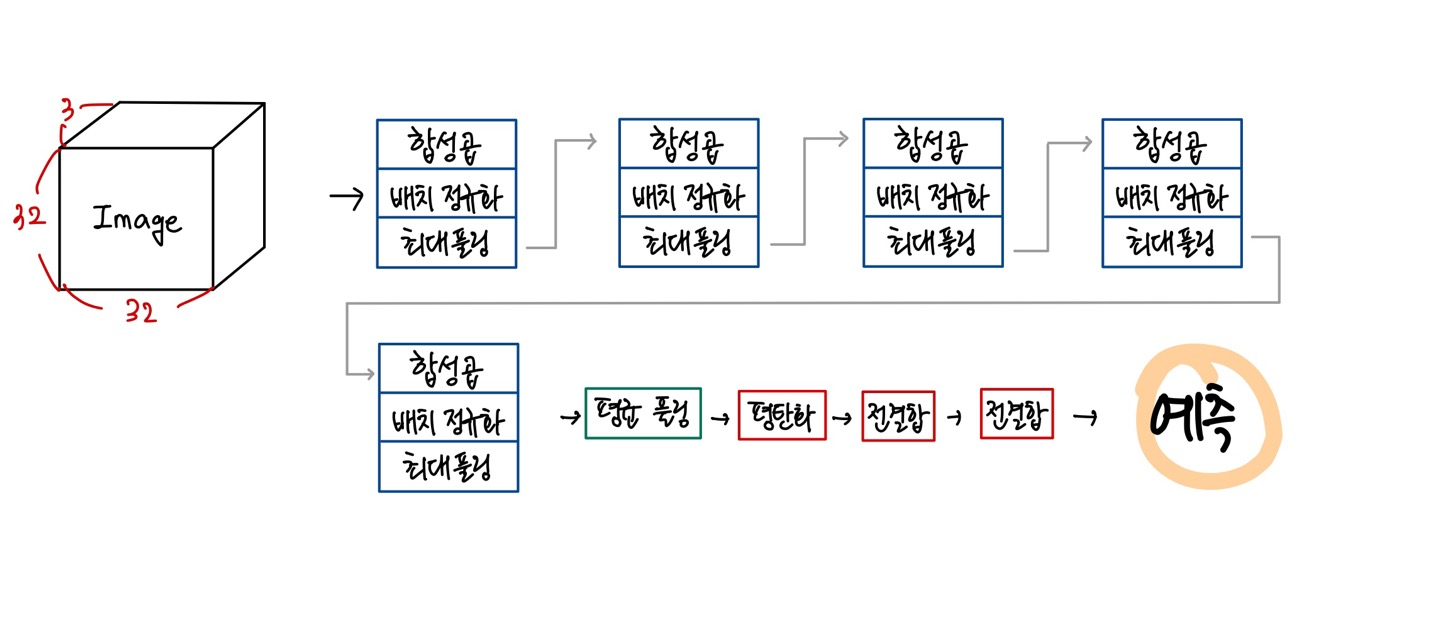

`nn.Sequential()`을 활용해 신경망 계층을 설계한다.

In [33]:
import torch.nn as nn 
import torch.nn.functional as F 

class Model(nn.Module) : 
  def __init__(self) : 
    super().__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 32,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
      
    self.layer2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    self.layer3 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    self.layer4 = nn.Sequential(nn.Conv2d(in_channels = 128, out_channels = 256,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    self.layer5 = nn.Sequential(nn.Conv2d(in_channels = 256, out_channels = 512,
                                          kernel_size = 3, padding = 2),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    
    # 평균 풀링 계층
    self.avg_pool = nn.AvgPool2d(kernel_size = 4)

    # 전결합 계층
    self.fc1 = nn.Linear(in_features = 512 * 1 * 1, out_features = 64)
    self.fc2 = nn.Linear(in_features = 64, out_features = 2)

  # 순전파 출력 정의    
  def forward(self, x) :
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.avg_pool(x)
    x = x.view(-1, 512 * 1 * 1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [34]:
model = Model().to(device)

## 모델 훈련

### 손실 함수와 옵티마이저 설정

In [35]:
# loss function 
criterion = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.00006)

### 모델 훈련 
에폭 수를 10 -> 70으로 늘린다. (데이터 증강으로 인해 훈련할 데이터가 많아졌기 때문)

In [37]:
epochs = 70

for epoch in range(epochs) :
  epoch_loss = 0

  for images, labels in loader_train : 
    images = images.to(device)
    labels = labels.to(device)

    # 기울기 초기화
    optimizer.zero_grad()

    # 순전파
    outputs = model(images)

    # 손실 계산 
    loss = criterion(outputs, labels)

    # 손실 추가
    epoch_loss += loss.item()

    # 역전파
    loss.backward()

    # 가중치 갱신
    optimizer.step()

  # 에폭마다 손실값 출력
  print(f'epoch [{epoch + 1} / {epochs}] - loss : {epoch_loss / len(loader_train):.4f}')

epoch [1 / 70] - loss : 0.1252
epoch [2 / 70] - loss : 0.0652
epoch [3 / 70] - loss : 0.0501
epoch [4 / 70] - loss : 0.0446
epoch [5 / 70] - loss : 0.0384
epoch [6 / 70] - loss : 0.0338
epoch [7 / 70] - loss : 0.0322
epoch [8 / 70] - loss : 0.0285
epoch [9 / 70] - loss : 0.0266
epoch [10 / 70] - loss : 0.0257
epoch [11 / 70] - loss : 0.0256
epoch [12 / 70] - loss : 0.0197
epoch [13 / 70] - loss : 0.0216
epoch [14 / 70] - loss : 0.0176
epoch [15 / 70] - loss : 0.0187
epoch [16 / 70] - loss : 0.0185
epoch [17 / 70] - loss : 0.0183
epoch [18 / 70] - loss : 0.0162
epoch [19 / 70] - loss : 0.0159
epoch [20 / 70] - loss : 0.0144
epoch [21 / 70] - loss : 0.0154
epoch [22 / 70] - loss : 0.0151
epoch [23 / 70] - loss : 0.0164
epoch [24 / 70] - loss : 0.0142
epoch [25 / 70] - loss : 0.0122
epoch [26 / 70] - loss : 0.0103
epoch [27 / 70] - loss : 0.0159
epoch [28 / 70] - loss : 0.0119
epoch [29 / 70] - loss : 0.0103
epoch [30 / 70] - loss : 0.0099
epoch [31 / 70] - loss : 0.0102
epoch [32 / 70] -

## 성능 검증 

In [38]:
from sklearn.metrics import roc_auc_score

true_list = [] 
preds_list = [] 

model.eval()

with torch.no_grad() :
  for images, labels in loader_valid : 
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    preds = torch.softmax(outputs.cpu(), dim = 1)[:, 1]
    true = labels.cpu()

    preds_list.extend(preds)
    true_list.extend(true)

print(f'valid set roc-auc : {roc_auc_score(true_list, preds_list):.4f}')

valid set roc-auc : 0.9999


## 예측 및 결과 제출

In [39]:
dataset_test = ImageDataset(df = submission, img_dir = 'test/',
                            transform = transform_test)

loader_test = DataLoader(dataset = dataset_test, batch_size = 32, shuffle = False)

model.eval()
preds = [] 

with torch.no_grad() : 
  for images, _ in loader_test : 
    images = images.to(device)

    outputs = model(images)
    preds_part = torch.softmax(outputs.cpu(), dim = 1)[:, 1].tolist()
    preds.extend(preds_part)

submission['has_cactus'] = preds
submission.to_csv('submission.csv', index = False)

In [40]:
import shutil

shutil.rmtree('./train')
shutil.rmtree('./test')